# Example: Quantum Deep Learning on Dynex (scikit-learn)

This examples shows using the Dynex SDK Scikit package which provides a scikit-learn transformer for feature selection using the Dynex Neuromorphic Computing Platform. The number of features have impact on neural network training and accuracy. It will be demonstrated how a significant reduction of features lead to similar (or even better) results.

In [1]:
import dynex
import dynex_scikit

## Dataset: Breast Cancer Wisconsin 

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.  They describe
characteristics of the cell nuclei present in the image.

Separating plane described above was obtained using Multisurface Method-Tree (MSM-T) [K. P. Bennett, "Decision Tree Construction Via Linear Programming." Proceedings of the 4th Midwest Artificial Intelligence and Cognitive Science Society, pp. 97-101, 1992], a classification method which uses linear programming to construct a decision tree.  Relevant features were selected using an exhaustive search in the space of 1-4 features and 1-3 separating planes.

The actual linear program used to obtain the separating plane in the 3-dimensional space is that described in:
[K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets",
Optimization Methods and Software 1, 1992, 23-34].

In [2]:
from sklearn.datasets import load_breast_cancer

In [3]:
X_cancer, y_cancer = load_breast_cancer(return_X_y=True)

In [4]:
X_cancer.shape

(569, 30)

# Deep Neural Network

First we load the required sklearn libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

Sklearn provides multiple activation functions. We first visualise the different functions:

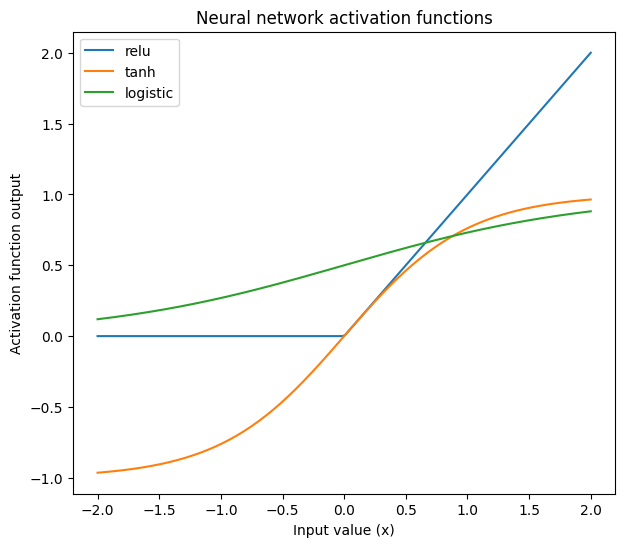

In [6]:
xrange = np.linspace(-2, 2, 200)
plt.figure(figsize=(7,6))
plt.plot(xrange, np.maximum(xrange, 0), label = 'relu')
plt.plot(xrange, np.tanh(xrange), label = 'tanh')
plt.plot(xrange, 1 / (1 + np.exp(-xrange)), label = 'logistic')
plt.legend()
plt.title('Neural network activation functions')
plt.xlabel('Input value (x)')
plt.ylabel('Activation function output')
plt.show()

## Data Preparation

We have to divide the dataset into training und validation (test) data and are also scaling the data.

In [7]:
scaler = MinMaxScaler();
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Training Datapoints: ',len(X_train), 'Validation Datapoints:', len(X_test))
print('Features:', X_cancer.shape[1])

Training Datapoints:  426 Validation Datapoints: 143
Features: 30


The original Breast Cancer dataset has 30 features.

## Using Dynex SciKit Plugin to reduce the number of features and run the model

We can run a Quantum algorithm for feature selection to find the relevant features of the breast-cancer dataset. This is being done by calling the Dynex Scikit-Learn plugin "SelectFromQuadraticModel" where we can specify the target number of features. We want to reduce the number of features by 33%, leaving only 20 features:

In [8]:
X_new = dynex_scikit.SelectFromQuadraticModel(num_features=20).fit_transform(X_cancer, y_cancer)

[DYNEX] MODEL CONVERTED TO QUBO
[DYNEX] PRECISION SET TO 0.1
[DYNEX] QUBO: Constant offset of the binary quadratic model: 63485.2813713015
[DYNEX] SAMPLER INITIALISED
[DYNEX|TESTNET] *** WAITING FOR READS ***
╭────────────┬───────────┬───────────────────────────┬─────────┬─────┬─────────┬───────┬─────┬──────────┬─────╮
│ DYNEXJOB   │ ELAPSED   │ WORKERS                   │ CHIPS   │ ✔   │ STEPS   │ LOC   │ ✔   │ ENERGY   │ ✔   │
├────────────┼───────────┼───────────────────────────┼─────────┼─────┼─────────┼───────┼─────┼──────────┼─────┤
│            │           │ *** WAITING FOR READS *** │         │     │         │       │     │          │     │
╰────────────┴───────────┴───────────────────────────┴─────────┴─────┴─────────┴───────┴─────┴──────────┴─────╯

[DYNEX] FINISHED READ AFTER 0.00 SECONDS
[DYNEX] SAMPLESET LOADED
Best energy: -58.997019167966016 feasible? True


The variable X_new contains the scikit-learn transformed data and has now 20 features:

In [9]:
X_new.shape

(569, 20)

We perform the same training method as above, but with the breast-cancer dataset reduced to 20 features:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_cancer, random_state = 0)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
clf = MLPClassifier(hidden_layer_sizes = [100, 100], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

In [12]:
print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

Breast cancer dataset
Accuracy of NN classifier on training set: 0.98
Accuracy of NN classifier on test set: 0.97


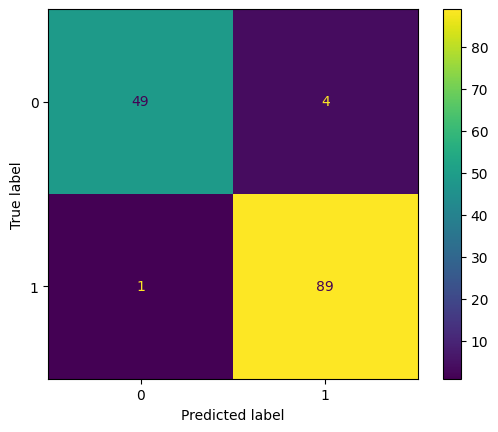

In [13]:
y_pred = clf.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

The resulting trained model shows less false positives and has similar accuracy values, even though it was trained with just 2/3 of the features from the original dataset.

References:

[1] Milne, Andrew, Maxwell Rounds, and Phil Goddard. 2017. "Optimal Feature Selection in Credit Scoring and Classification Using a Quantum Annealer." 1QBit; White Paper. https://1qbit.com/whitepaper/optimal-feature-selection-in-credit-scoring-classification-using-quantum-annealer/